In [1]:
%matplotlib inline
import sys
import shutil
import time
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import argparse
import matplotlib.pyplot as plt
from networks import *
from normal_train import *
import numpy as np
import copy
import math
def sum_of_all_parameter(model):
    res = 0
    if isinstance(model, TwoLayerReluASI):
        for p in model.features1:
            if p.__class__.__name__=="Linear":
                res+=np.linalg.norm(p.weight.detach().numpy().squeeze())

        for p in model.features2:
            if p.__class__.__name__=="Linear":
                res+=np.linalg.norm(p.weight.detach().numpy().squeeze())
    else:
        for p in model.features:
            if p.__class__.__name__=="Linear":
                res+=np.linalg.norm(p.weight.detach().numpy().squeeze())

    return res

def two_relu_layer_train(num_neurons=100):
    epochs = 100000
    path = '/home/huijin/seminar project/model/'

    #     tag='sgd_epoch'+str(epochs)+'_init_'+str(initialization)+'_lr_'+str(learning_rate)+'_bs_'+str(batch_size)+'_network_'+network_choice
    tag = 'toy_model_'+str(num_neurons)

    model = TwoLayerReluASI(num_neurons=num_neurons, bias_tune="uniform [-2,2]")

    global best_acc
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    use_cuda = True
    best_loss = 1000000
    old_loss = 10
    learning_rate = 0.03 #0.02
    #     momentum = 0.9
    #     weight_decay = 5e-4
    # Data
    #     dataloader = datasets.CIFAR10
    #     train_batch = batch_size #128
    #     test_batch = 100
    workers = 1
    decay_epoch = 100000
    use_cuda = False

    #     if accumulation_steps*batch_size/learning_rate>=4096/0.02:
    #         decay_epoch = 250
    #         epochs = 400
    #     elif accumulation_steps*batch_size/learning_rate>=4096/0.04:
    #         decay_epoch = 200
    #         epochs = 350

    xp = np.array([-2, -1, 0, 1, 2],dtype=np.float)
    fp = [1.5, 0.5, 1.5, 0.5, 1.5]
    # train_input = np.sort(np.concatenate((np.random.uniform(-2,2,30),xp))).astype(np.float32)
    train_input = np.sort(xp).astype(np.float32)
    train_output = np.interp(train_input, xp, fp).astype(np.float32)

    trainset = [(train_input[i:i+1], train_output[i:i+1]) for i in range(train_input.shape[0])]
    trainloader = data.DataLoader(trainset, batch_size=train_input.shape[0], shuffle=True, num_workers=workers)
    #     testset = dataloader(root='/home/huijin/large-batch-training-torch/data', train=False, download=False, transform=transform_test)
    #     testloader = data.DataLoader(testset, batch_size=test_batch, shuffle=False, num_workers=workers)

    #     model = AlexNet(10)
    #     model_state = torch.load('model_38')
    #     model.load_state_dict(model_state)

    criterion = nn.MSELoss()
    #     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay= weight_decay)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    if use_cuda == True:
        model = model.cuda()
        criterion = criterion.cuda()

    # Initialization

    #     initial_model_file = '/home/huijin/large-batch-training-torch/model/init_'+str(initialization)+'_network_'+network_choice
    #     if os.path.isfile(initial_model_file):
    #         model_state = torch.load(initial_model_file)
    #         model.load_state_dict(model_state)
    #     else:
    #         torch.save(model.state_dict(), initial_model_file)
    inital_norm_weight = sum_of_all_parameter(model)
    # Train and val
    history = dict(loss=list(),val_loss=list(),acc=list(),val_acc=list())
    old_loss = test(trainloader, model, criterion, 0, use_cuda)+0.01
    for epoch in range(start_epoch, epochs):
#         import ipdb; ipdb.set_trace() 
        old_state_dict = copy.deepcopy(model.state_dict())
#         print(old_state_dict)
        train_loss = train(trainloader, model, criterion, optimizer, epoch, use_cuda)
    #         test_loss, test_acc = test(testloader, model, criterion, epoch, use_cuda)
        train_loss = test(trainloader, model, criterion, epoch, use_cuda)
        print('Epoch: [%d | %d] LR: %f; Train Loss %f'
              % (epoch + 1, epochs, optimizer.param_groups[0]['lr'],train_loss))
        sys.stdout.flush()
        history['loss'].append(train_loss)

        # save model
        is_best = train_loss < best_loss
        best_loss = min(train_loss, best_loss)
        if is_best:
            torch.save(model.state_dict(), path+tag+'_best'+"uniform [-2,2]")
        # torch.save(model.state_dict(), '/home/huijin/large-batch-training-torch/model/'+tag+'model_batch_'+str(epoch+1))

        if train_loss > old_loss:
            model.load_state_dict(old_state_dict)
            learning_rate = learning_rate*0.5
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] *= 1.0/2
        else:
            if epoch % decay_epoch == (decay_epoch-1):
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.5
            if abs(old_loss-train_loss)<1e-9:
                break
            old_loss = train_loss

    torch.save(model.state_dict(), path+tag)
    
    end_norm_weight = sum_of_all_parameter(model)
    
    test_input = np.arange(-2 , 2 , 0.01).astype(np.float32)
    testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
    testloader = data.DataLoader(testset, batch_size=test_input.shape[0], shuffle=False, num_workers=workers)
    for batch_idx, inputs in enumerate(testloader):
        outputs = model(inputs)
    test_output = outputs.squeeze().detach().numpy()
    true_output = np.interp(test_input, xp, fp)
    away_from_piecewise_linear = np.mean((true_output-test_output)**2)
    return (inital_norm_weight, end_norm_weight, away_from_piecewise_linear, train_loss)

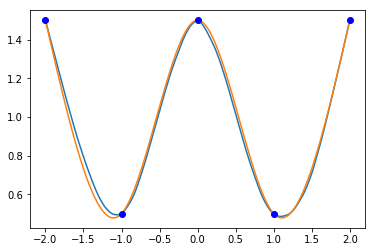

In [17]:
#original case

from scipy.interpolate import CubicSpline
xp = np.array([-2, -1, 0, 1, 2],dtype=np.float)
fp = [1.5, 0.5, 1.5, 0.5, 1.5]
cubic_spline = CubicSpline(xp, fp, bc_type='natural', extrapolate=False)

num_neurons = 640
model = TwoLayerReluASI(num_neurons=num_neurons)
path = '/home/huijin/seminar project/model/'
tag = 'toy_model_original_'+str(num_neurons)
model_state = torch.load(path+tag+'_best'+"uniform [-2,2]")
model.load_state_dict(model_state)

test_input = np.arange(-2 , 2 , 0.01).astype(np.float32)
testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
testloader = data.DataLoader(testset, batch_size=test_input.shape[0], shuffle=False, num_workers=1)
for batch_idx, inputs in enumerate(testloader):
    outputs = model(inputs)
test_output = outputs.squeeze().detach().numpy()
true_output = np.interp(test_input, xp, fp)
# print(np.mean((true_output-test_output)**2))

fig, ax = plt.subplots()
plt.plot(test_input,test_output)
plt.plot(test_input,cubic_spline(test_input))
plt.plot(xp,fp,'bo')

In [26]:
xp = np.array([-1.9415253 , -1.83502583, -1.82786533, -1.80140037, -1.73514521,
       -1.69448792, -1.4435885 , -1.40667158, -1.27905156, -1.18444905,
       -1.17980971, -1.05102099, -1.04600602, -1.00527309, -0.96346712,
       -0.95689318, -0.92929648, -0.79841429, -0.79689293, -0.74430997,
       -0.68031029, -0.66002798, -0.64820833, -0.63712357, -0.63620816,
       -0.61509683, -0.61409385, -0.59207649, -0.53717422, -0.47286105,
       -0.47038684, -0.4501469 , -0.4075698 , -0.38922321, -0.38357416,
       -0.34749539, -0.26260681, -0.25762132, -0.24873869, -0.22855266,
       -0.17541225, -0.14241776, -0.13302821, -0.07871058, -0.06967556,
       -0.05292079,  0.0187335 ,  0.03295548,  0.03677834,  0.0778486 ,
        0.08046378,  0.23012608,  0.29737316,  0.30220436,  0.32766369,
        0.37341057,  0.44910199,  0.45729332,  0.50784799,  0.50861522,
        0.58190852,  0.6234433 ,  0.64045264,  0.65463741,  0.74295083,
        0.82675226,  0.84058051,  0.94995706,  0.96409741,  1.0035864 ,
        1.04948827,  1.06144718,  1.11993816,  1.15760546,  1.22624714,
        1.24653998,  1.28590405,  1.30407315,  1.31858575,  1.33918314,
        1.35314048,  1.36891959,  1.40635244,  1.42523788,  1.49800644,
        1.53955918,  1.54275751,  1.56619793,  1.59799169,  1.63437946,
        1.64509328,  1.69015567,  1.77862659,  1.81539186,  1.82155336,
        1.83535226,  1.86778134,  1.87530124,  1.91165682,  1.98848334])
fp = [2.61304277, 1.95817307, 1.91823434, 1.77668057, 1.4719204 ,
       1.3273833 , 1.28113575, 1.3663114 , 1.73194548, 2.00455122,
       2.01661786, 2.25285802, 2.25701316, 2.27259393, 2.25107661,
       2.24387321, 2.20139188, 1.77552308, 1.76923552, 1.54746632,
       1.2900388 , 1.21773571, 1.17866031, 1.14436253, 1.14163891,
       1.08385281, 1.08136122, 1.03307863, 0.97346778, 1.01057496,
       1.01403272, 1.0474021 , 1.14470901, 1.19668846, 1.21378471,
       1.33382139, 1.67455541, 1.69648779, 1.73595975, 1.82732495,
       2.0753956 , 2.23162355, 2.27597573, 2.52795976, 2.56865978,
       2.64284001, 2.93435071, 2.98587871, 2.99930419, 3.13098155,
       3.1385288 , 3.35523353, 3.2798598 , 3.26947679, 3.20293652,
       3.03093488, 2.62130046, 2.57094137, 2.24966915, 2.24474612,
       1.79433583, 1.57808675, 1.50279548, 1.44715876, 1.28756806,
       1.43999465, 1.48627791, 1.96660737, 2.03519859, 2.22265944,
       2.41947268, 2.46469103, 2.6378668 , 2.70814342, 2.76094073,
       2.75943162, 2.73620505, 2.71698179, 2.69799323, 2.66575493,
       2.6405377 , 2.60890352, 2.52146641, 2.47123918, 2.24500977,
       2.09668662, 2.08480367, 1.99595813, 1.87118549, 1.72384725,
       1.67980394, 1.49277943, 1.12840576, 0.98297449, 0.95904166,
       0.90585752, 0.78289943, 0.75474795, 0.62021713, 0.34149254]

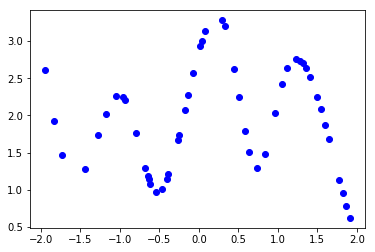

In [28]:
xp = xp[0::2]
fp = fp[0::2]
plt.plot(xp,fp,'bo')

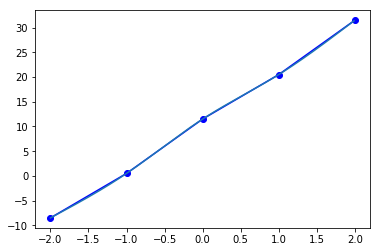

In [25]:
xp1 = np.array([-2, -1, 0, 1, 2],dtype=np.float)
fp1 = np.array([1.5, 0.5, 1.5, 0.5, 1.5],dtype=np.float)+10+10*xp1
plt.plot(xp1,fp1,'bo-')
cubic_spline = CubicSpline(xp1, fp1, bc_type='natural', extrapolate=False)
plt.plot(test_input,cubic_spline(test_input))

0.0035260122525084163


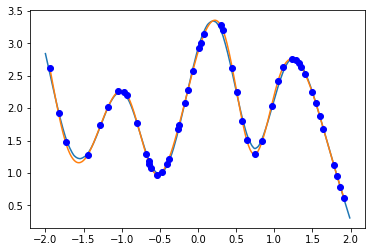

In [62]:
# many inputs
from scipy.interpolate import CubicSpline
xp = np.array([-1.9415253 , -1.83502583, -1.82786533, -1.80140037, -1.73514521,
       -1.69448792, -1.4435885 , -1.40667158, -1.27905156, -1.18444905,
       -1.17980971, -1.05102099, -1.04600602, -1.00527309, -0.96346712,
       -0.95689318, -0.92929648, -0.79841429, -0.79689293, -0.74430997,
       -0.68031029, -0.66002798, -0.64820833, -0.63712357, -0.63620816,
       -0.61509683, -0.61409385, -0.59207649, -0.53717422, -0.47286105,
       -0.47038684, -0.4501469 , -0.4075698 , -0.38922321, -0.38357416,
       -0.34749539, -0.26260681, -0.25762132, -0.24873869, -0.22855266,
       -0.17541225, -0.14241776, -0.13302821, -0.07871058, -0.06967556,
       -0.05292079,  0.0187335 ,  0.03295548,  0.03677834,  0.0778486 ,
        0.08046378,  0.23012608,  0.29737316,  0.30220436,  0.32766369,
        0.37341057,  0.44910199,  0.45729332,  0.50784799,  0.50861522,
        0.58190852,  0.6234433 ,  0.64045264,  0.65463741,  0.74295083,
        0.82675226,  0.84058051,  0.94995706,  0.96409741,  1.0035864 ,
        1.04948827,  1.06144718,  1.11993816,  1.15760546,  1.22624714,
        1.24653998,  1.28590405,  1.30407315,  1.31858575,  1.33918314,
        1.35314048,  1.36891959,  1.40635244,  1.42523788,  1.49800644,
        1.53955918,  1.54275751,  1.56619793,  1.59799169,  1.63437946,
        1.64509328,  1.69015567,  1.77862659,  1.81539186,  1.82155336,
        1.83535226,  1.86778134,  1.87530124,  1.91165682,  1.98848334])
fp = [2.61304277, 1.95817307, 1.91823434, 1.77668057, 1.4719204 ,
       1.3273833 , 1.28113575, 1.3663114 , 1.73194548, 2.00455122,
       2.01661786, 2.25285802, 2.25701316, 2.27259393, 2.25107661,
       2.24387321, 2.20139188, 1.77552308, 1.76923552, 1.54746632,
       1.2900388 , 1.21773571, 1.17866031, 1.14436253, 1.14163891,
       1.08385281, 1.08136122, 1.03307863, 0.97346778, 1.01057496,
       1.01403272, 1.0474021 , 1.14470901, 1.19668846, 1.21378471,
       1.33382139, 1.67455541, 1.69648779, 1.73595975, 1.82732495,
       2.0753956 , 2.23162355, 2.27597573, 2.52795976, 2.56865978,
       2.64284001, 2.93435071, 2.98587871, 2.99930419, 3.13098155,
       3.1385288 , 3.35523353, 3.2798598 , 3.26947679, 3.20293652,
       3.03093488, 2.62130046, 2.57094137, 2.24966915, 2.24474612,
       1.79433583, 1.57808675, 1.50279548, 1.44715876, 1.28756806,
       1.43999465, 1.48627791, 1.96660737, 2.03519859, 2.22265944,
       2.41947268, 2.46469103, 2.6378668 , 2.70814342, 2.76094073,
       2.75943162, 2.73620505, 2.71698179, 2.69799323, 2.66575493,
       2.6405377 , 2.60890352, 2.52146641, 2.47123918, 2.24500977,
       2.09668662, 2.08480367, 1.99595813, 1.87118549, 1.72384725,
       1.67980394, 1.49277943, 1.12840576, 0.98297449, 0.95904166,
       0.90585752, 0.78289943, 0.75474795, 0.62021713, 0.34149254]
xp = xp[0::2]
fp = fp[0::2]
cubic_spline = CubicSpline(xp, fp, bc_type='natural', extrapolate=False)

num_neurons = 5120
model = TwoLayerReluASI(num_neurons=num_neurons)
path = '/home/huijin/seminar project/model/'
tag = 'toy_model_many_inputs_cont'+str(num_neurons)+'_best'+"uniform [-2,2]"
model_state = torch.load(path+tag)
model.load_state_dict(model_state)

test_input = np.arange(-2 , 2 , 0.01).astype(np.float32)
testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
testloader = data.DataLoader(testset, batch_size=test_input.shape[0], shuffle=False, num_workers=1)
for batch_idx, inputs in enumerate(testloader):
    outputs = model(inputs)
test_output = outputs.squeeze().detach().numpy()
true_output = np.interp(test_input, xp, fp)
print(np.mean((true_output-test_output)**2))

fig, ax = plt.subplots()
plt.plot(test_input,test_output)
plt.plot(test_input,cubic_spline(test_input))
plt.plot(xp,fp,'bo')

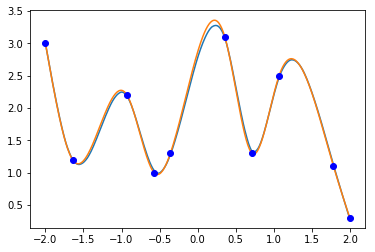

In [4]:
from scipy.interpolate import CubicSpline
xp = (np.array([-2, -1.5, -0.5, 0  , 0.3, 1.3, 1.8, 2.3, 3.3, 3.6])+2)/5.6*4-2
fp = [ 3,  1.2,  2.2, 1.0, 1.3, 3.1, 1.3, 2.5, 1.1, 0.3]
cubic_spline = CubicSpline(xp, fp, bc_type='natural', extrapolate=False)

num_neurons = 10240
model = TwoLayerReluASI(num_neurons=num_neurons)
path = '/home/huijin/seminar project/model/'
tag = 'toy_model_'+str(num_neurons)
model_state = torch.load(path+tag+'_best'+"uniform [-2,2]")
model.load_state_dict(model_state)

test_input = np.arange(-2 , 2 , 0.01).astype(np.float32)
testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
testloader = data.DataLoader(testset, batch_size=test_input.shape[0], shuffle=False, num_workers=1)
for batch_idx, inputs in enumerate(testloader):
    outputs = model(inputs)
test_output = outputs.squeeze().detach().numpy()
true_output = np.interp(test_input, xp, fp)
# print(np.mean((true_output-test_output)**2))

fig, ax = plt.subplots()
plt.plot(test_input,test_output)
plt.plot(test_input,cubic_spline(test_input))
plt.plot(xp,fp,'bo')

0.004594346001315155

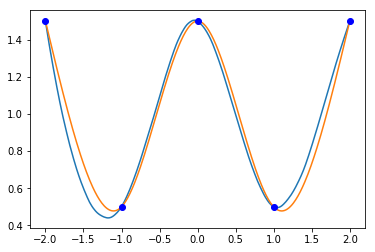

In [46]:
#large linear
from scipy.interpolate import CubicSpline
xp = np.array([-2, -1, 0, 1, 2],dtype=np.float)
fp = np.array([1.5, 0.5, 1.5, 0.5, 1.5],dtype=np.float)+10+10*xp
cubic_spline = CubicSpline(xp, fp, bc_type='natural', extrapolate=False)

num_neurons = 5120
model = TwoLayerReluASI(num_neurons=num_neurons)
path = '/home/huijin/seminar project/model/'
tag = 'toy_model_large_linear_'+str(num_neurons)
model_state = torch.load(path+tag)
model.load_state_dict(model_state)

test_input = np.arange(-2 , 2 , 0.01).astype(np.float32)
testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
testloader = data.DataLoader(testset, batch_size=test_input.shape[0], shuffle=False, num_workers=1)
for batch_idx, inputs in enumerate(testloader):
    outputs = model(inputs)
test_output = outputs.squeeze().detach().numpy()
true_output = np.interp(test_input, xp, fp)
# print(np.mean((true_output-test_output)**2))

fig, ax = plt.subplots()
plt.plot(test_input,test_output-(+10+10*test_input))
plt.plot(test_input,cubic_spline(test_input)-(+10+10*test_input))
plt.plot(xp,fp-(+10+10*xp),'bo')
np.mean((test_output-cubic_spline(test_input))**2)

In [5]:
# Gaussian
from scipy.optimize import minimize
xp = np.array([-2, -1, 0, 1, 2],dtype=np.float)
fp = [1.5, 0.5, 1.5, 0.5, 1.5]

num = 101
h = (2-(-2))/(num-1)
grid = np.linspace(start = -2, stop = 2, num = num)
weight = (1+grid**2)**2
f = np.zeros((num))
xp_loc = (xp-(-2))/h
f[xp_loc.astype(np.int16)]=fp
def mf(ff):
    ff[xp_loc.astype(np.int16)]=fp
    return ff
fun = lambda ff: np.sum(((mf(ff)[2:]+mf(ff)[0:-2]
                          -2*mf(ff)[1:-1])**2)*weight[1:-1])
res = minimize(fun, f, method='CG', options={'gtol': 1e-4, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.005054
         Iterations: 3829
         Function evaluations: 598121
         Gradient evaluations: 5807


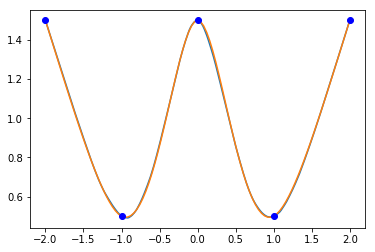

In [18]:
# Gaussian
from scipy.interpolate import CubicSpline
xp = np.array([-2, -1, 0, 1, 2],dtype=np.float)
fp = [1.5, 0.5, 1.5, 0.5, 1.5]


num_neurons = 1280
model = TwoLayerReluASI(num_neurons=num_neurons)
path = '/home/huijin/seminar project/model/'
tag = 'toy_model_gaussian_'+str(num_neurons)
model_state = torch.load(path+tag+'_best'+"uniform [-2,2]")
model.load_state_dict(model_state)

test_input = np.arange(-2 , 2 , 0.01).astype(np.float32)
testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
testloader = data.DataLoader(testset, batch_size=test_input.shape[0], shuffle=False, num_workers=1)
for batch_idx, inputs in enumerate(testloader):
    outputs = model(inputs)
test_output = outputs.squeeze().detach().numpy()
true_output = np.interp(test_input, xp, fp)
# print(np.mean((true_output-test_output)**2))

fig, ax = plt.subplots()
plt.plot(test_input,test_output)
plt.plot(grid,res.x)
plt.plot(xp,fp,'bo')

In [15]:
# Gaussian 0.1
from scipy.optimize import minimize
xp = np.array([-2, -1, 0, 1, 2],dtype=np.float)
fp = [1.5, 0.5, 1.5, 0.5, 1.5]

num = 101
h = (2-(-2))/(num-1)
grid = np.linspace(start = -2, stop = 2, num = num)
weight = (0.1+grid**2)**2
f = np.zeros((num))
xp_loc = (xp-(-2))/h
f[xp_loc.astype(np.int16)]=fp
def mf(ff):
    ff[xp_loc.astype(np.int16)]=fp
    return ff
fun = lambda ff: np.sum(((mf(ff)[2:]+mf(ff)[0:-2]
                          -2*mf(ff)[1:-1])**2)*weight[1:-1])
res = minimize(fun, f, method='CG', options={'gtol': 1e-6, 'disp': True})

         Current function value: 0.000528
         Iterations: 20200
         Function evaluations: 3258096
         Gradient evaluations: 31632


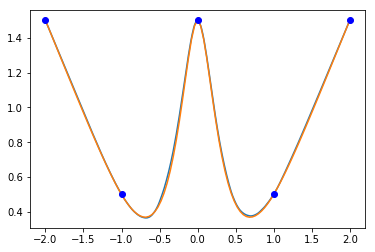

In [31]:
# Gaussian 0.1
from scipy.interpolate import CubicSpline
xp = np.array([-2, -1, 0, 1, 2],dtype=np.float)
fp = [1.5, 0.5, 1.5, 0.5, 1.5]


num_neurons = 2560
model = TwoLayerReluASI(num_neurons=num_neurons)
path = '/home/huijin/seminar project/model/'
tag = 'toy_model_gaussian_0.1_variance'+str(num_neurons)
model_state = torch.load(path+tag+'_best'+"uniform [-2,2]")
model.load_state_dict(model_state)

test_input = np.arange(-2 , 2 , 0.01).astype(np.float32)
testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
testloader = data.DataLoader(testset, batch_size=test_input.shape[0], shuffle=False, num_workers=1)
for batch_idx, inputs in enumerate(testloader):
    outputs = model(inputs)
test_output = outputs.squeeze().detach().numpy()
true_output = np.interp(test_input, xp, fp)
# print(np.mean((true_output-test_output)**2))

fig, ax = plt.subplots()
plt.plot(test_input,test_output)
plt.plot(grid,res.x)
plt.plot(xp,fp,'bo')

(array([3.000e+00, 5.000e+01, 2.960e+02, 1.245e+03, 2.586e+03, 3.172e+03,
        2.022e+03, 7.010e+02, 1.520e+02, 1.300e+01]),
 array([-1.3352181 , -1.0821569 , -0.8290957 , -0.5760346 , -0.32297343,
        -0.06991225,  0.1831489 ,  0.43621007,  0.6892712 ,  0.9423324 ,
         1.1953936 ], dtype=float32),
 <a list of 10 Patch objects>)

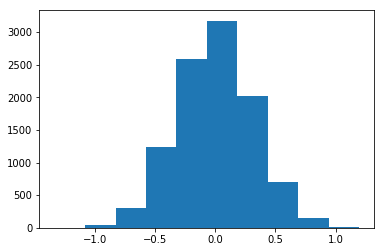

In [56]:
plt.hist(model.features1[0].bias.detach().numpy())

In [2]:
import numpy as np
x=[10,20,40,80,160,320,640,1280,2560,5120,10240]
y=np.array([0.4457557561225264, 0.3848092856850927, 0.37554777281690715, 0.33098726079585195, 0.2208001303178743, 0.07794031184966761, 0.04360548475345538, 0.01888420644799352, 0.00743752020394902, 0.002675987558404774, 0.0010114845346919136])
error=np.array([0.012281710714024674, 8.101794735801415e-05, 0.00013003358825883216, 0.00011555972381419033, 0.0007251920945845342, 0.0007373853289350122, 3.764140215981233e-05, 7.222433945300462e-06, 7.644670842244558e-07, 7.987093682546043e-07, 1.4387953768324918e-07])

In [12]:
np.sqrt(error)/np.sqrt(y)/2

array([0.08299481, 0.00725501, 0.0093039 , 0.0093426 , 0.02865477,
       0.04863357, 0.01469036, 0.00977828, 0.00506915, 0.00863818,
       0.00596334])

In [13]:
np.sqrt(y)

array([0.66764943, 0.62032998, 0.61281953, 0.57531492, 0.46989374,
       0.27917792, 0.20881926, 0.13741982, 0.08624106, 0.05172995,
       0.03180384])

In [14]:
np.sqrt(error)

array([0.11082288, 0.009001  , 0.01140323, 0.01074987, 0.02692939,
       0.02715484, 0.00613526, 0.00268746, 0.00087434, 0.00089371,
       0.00037931])

In [19]:
np.sqrt(error)/np.sqrt(y)/2/np.sqrt(y)

array([0.12430897, 0.0116954 , 0.01518213, 0.0162391 , 0.06098137,
       0.17420279, 0.07034962, 0.07115625, 0.05877887, 0.16698609,
       0.18750389])

In [3]:
from sklearn.linear_model import LinearRegression
start = 5
n = np.log(x[start:]).shape[0]
X = np.zeros((n,1))
X[:,0] = np.log(x[start:])
# X[:,1] = np.ones(n)
y_s = np.log(np.sqrt(y[start:]))
reg = LinearRegression().fit(X, y_s)
reg.score(X, y_s)

0.9927478601305734

In [65]:
reg.coef_

array([-0.63946433])

In [66]:
reg.intercept_

2.515509067093988

In [68]:
np.exp(2.515509067093988)

12.372905815376846

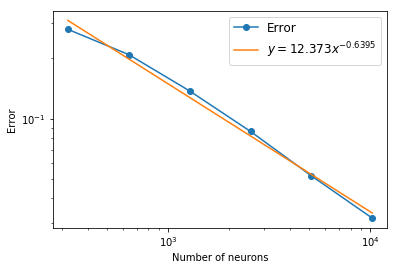

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax0= plt.subplots()
# ax0.errorbar(x[1:], np.sqrt(y[1:]), yerr=np.sqrt(error[1:])/np.sqrt(y[1:])/2, fmt='-o')
ax0.loglog(x[start:], np.sqrt(y[start:]), '-o')
plt.xlabel("Number of neurons")
plt.ylabel("Error")
n_line = np.linspace(320,10240,1000).shape[0]
X_line = np.zeros((n_line,1))
X_line[:,0] = np.linspace(320,10240,1000)
ax0.loglog(X_line[:,0], np.exp(reg.predict(np.log(X_line))))
ax0.legend(['Error',"$y=12.373x^{-0.6395}$"],fontsize='large')

In [11]:
from scipy.optimize import minimize
# train_input = np.sort(np.concatenate((np.random.uniform(-2,2,30),xp))).astype(np.float32)
train_input = np.sort(xp).astype(np.float32)
train_output = np.interp(train_input, xp, fp).astype(np.float32)

num = 101
h = (2-(-2))/(num-1)
grid = np.linspace(start = -2, stop = 2, num = num)
weight = (1+grid**2)**2
f = np.zeros((num))
xp_loc = (xp-(-2))/h
f[xp_loc.astype(np.int16)]=fp
def mf(ff):
    ff[xp_loc.astype(np.int16)]=fp
    return ff
fun = lambda ff: np.sum(((mf(ff)[2:]+mf(ff)[0:-2]
                          -2*mf(ff)[1:-1])**2)*weight[1:-1])
res = minimize(fun, f, method='CG', options={'gtol': 1e-4, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.005054
         Iterations: 3829
         Function evaluations: 598121
         Gradient evaluations: 5807


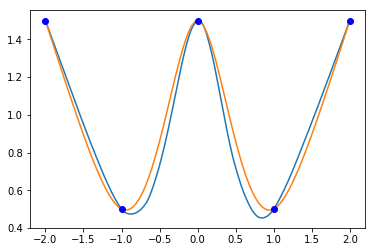

In [13]:
from scipy.interpolate import CubicSpline
xp = np.array([-2, -1, 0, 1, 2],dtype=np.float)
fp = [1.5, 0.5, 1.5, 0.5, 1.5]
cubic_spline = CubicSpline(xp, fp)

num_neurons = 1280
model = TwoLayerReluASI(num_neurons=num_neurons)
path = '/home/huijin/seminar project/model/'
tag = 'toy_model_gaussian_'+str(num_neurons)
model_state = torch.load(path+tag+'_best'+"uniform [-2,2]")
model.load_state_dict(model_state)

test_input = np.arange(-2 , 2 , 0.01).astype(np.float32)
testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
testloader = data.DataLoader(testset, batch_size=test_input.shape[0], shuffle=False, num_workers=1)
for batch_idx, inputs in enumerate(testloader):
    outputs = model(inputs)
test_output = outputs.squeeze().detach().numpy()
true_output = np.interp(test_input, xp, fp)
# print(np.mean((true_output-test_output)**2))

fig, ax = plt.subplots()
plt.plot(test_input,test_output)
# plt.plot(test_input,cubic_spline(test_input))
plt.plot(grid, res.x)
plt.plot(xp,fp,'bo')

(array([144., 136., 111., 144., 124., 138., 118., 129., 115., 121.]),
 array([-1.0000576 , -0.8007633 , -0.60146904, -0.40217477, -0.2028805 ,
        -0.00358623,  0.19570804,  0.3950023 ,  0.5942966 ,  0.79359084,
         0.9928851 ], dtype=float32),
 <a list of 10 Patch objects>)

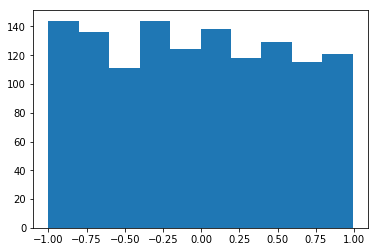

In [25]:
plt.hist(model.features1[0].bias.detach().numpy())

(array([  1.,   6.,  42., 146., 293., 373., 254., 127.,  32.,   6.]),
 array([-1.2463382 , -1.0155784 , -0.78481853, -0.5540587 , -0.3232988 ,
        -0.09253895,  0.1382209 ,  0.36898077,  0.5997406 ,  0.8305005 ,
         1.0612603 ], dtype=float32),
 <a list of 10 Patch objects>)

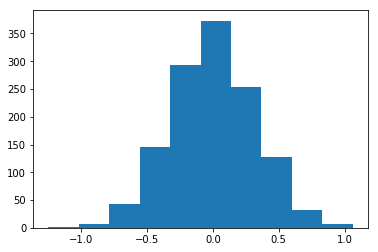

In [6]:
tmp = TwoLayerReluASI(num_neurons=1280, initialization="normal" , bias_tune="normal 0.1")
plt.hist(tmp.features1[0].bias.detach().numpy())

In [88]:
mf(np.zeros((num)))

array([1.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1.5, 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1.5])

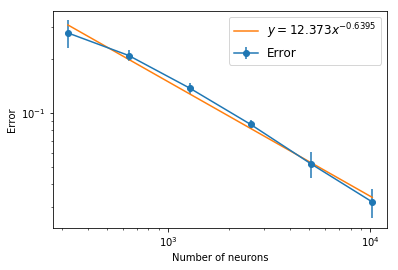

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax0= plt.subplots()
# ax0.errorbar(x[1:], np.sqrt(y[1:]), yerr=np.sqrt(error[1:])/np.sqrt(y[1:])/2, fmt='-o')
# ax0.loglog(x[start:], np.sqrt(y[start:]), '-o')
plt.xlabel("Number of neurons")
plt.ylabel("Error")
n_line = np.linspace(320,10240,1000).shape[0]
X_line = np.zeros((n_line,1))
X_line[:,0] = np.linspace(320,10240,1000)
ax0.set_xscale("log", nonposx='clip')
ax0.set_yscale("log", nonposy='clip')
# ax4.set(title='Errorbars go negative')
ax0.errorbar(x[start:], np.sqrt(y[start:]), yerr=(np.sqrt(error)/np.sqrt(y)/2)[start:], fmt='-o')
ax0.loglog(X_line[:,0], np.exp(reg.predict(np.log(X_line))))
ax0.legend(["$y=12.373x^{-0.6395}$",'Error'],fontsize='large')

In [90]:
error

array([1.22817107e-02, 8.10179474e-05, 1.30033588e-04, 1.15559724e-04,
       7.25192095e-04, 7.37385329e-04, 3.76414022e-05, 7.22243395e-06,
       7.64467084e-07, 7.98709368e-07, 1.43879538e-07])

In [91]:
np.sqrt(error)/np.sqrt(y)/2

array([0.08299481, 0.00725501, 0.0093039 , 0.0093426 , 0.02865477,
       0.04863357, 0.01469036, 0.00977828, 0.00506915, 0.00863818,
       0.00596334])

In [ ]:
#many inputs
import numpy as np
x=[10,20,40,80,160,320,640,1280,2560]
y=np.array([0.0444689599453739, 0.007748549296217705, 0.00584310160963839, 0.005708744793879639, 0.0033964321734444745, 0.0011195812600882464, 0.0007817084209496251, 0.00036721854540489626, 9.816690775638301e-05])
error=np.array([[0.00019879209209166778, 0.0015810328202742405, 0.0011046609003449808, 6.894614267375883e-05, 6.8983273993002e-06, 1.2778487721475313e-05, 1.5635011729051007e-05, 3.919142182289611e-06, 1.0040052916895643e-06, 1.3310643453791544e-06])
from sklearn.linear_model import LinearRegression
start = 2
n = np.log(x[start:]).shape[0]
X = np.zeros((n,1))
X[:,0] = np.log(x[start:])
# X[:,1] = np.ones(n)
y_s = np.log(np.sqrt(y[start:]))
reg = LinearRegression().fit(X, y_s)
reg.score(X, y_s)

%matplotlib inline
import matplotlib.pyplot as plt
fig, ax0= plt.subplots()
# ax0.errorbar(x[1:], np.sqrt(y[1:]), yerr=np.sqrt(error[1:])/np.sqrt(y[1:])/2, fmt='-o')
# ax0.loglog(x[start:], np.sqrt(y[start:]), '-o')
plt.xlabel("Number of neurons")
plt.ylabel("Error")
n_line = np.linspace(40,2560,1000).shape[0]
X_line = np.zeros((n_line,1))
X_line[:,0] = np.linspace(40,2560,1000)
ax0.set_xscale("log", nonposx='clip')
ax0.set_yscale("log", nonposy='clip')
# ax4.set(title='Errorbars go negative')
ax0.errorbar(x[start:], np.sqrt(y[start:]), yerr=(np.sqrt(error)/np.sqrt(y)/2)[start:], fmt='-o')
ax0.loglog(X_line[:,0], np.exp(reg.predict(np.log(X_line))))
ax0.legend(["$y="+str(np.exp(reg.intercept_))+"x^{"+str(reg.coef_)+"}$",'Error'],fontsize='large')

In [ ]:
#Gaussian
import numpy as np
x=[10,20,40,80,160,320,640,1280,2560]
y=np.array([0.5087838423008789, 0.17029626008666274, 0.11172634983483315, 0.03779847070468886, 0.016310560803574816, 0.007502495089343165, 0.0024358773018068407, 0.003040371520103424, 0.0009556105733299966, 0.0003391049195038465])
error=np.array([0.08970238246198681, 0.0027003632387685578, 0.0004969130566420156, 0.0006030839556948851, 0.00017413234502299815, 1.8090136014807644e-05, 9.859660750391001e-07, 7.273839710996208e-07, 4.667721522545346e-07, 1.0040740242108963e-08])
from sklearn.linear_model import LinearRegression
start = 2
n = np.log(x[start:]).shape[0]
X = np.zeros((n,1))
X[:,0] = np.log(x[start:])
# X[:,1] = np.ones(n)
y_s = np.log(np.sqrt(y[start:]))
reg = LinearRegression().fit(X, y_s)
reg.score(X, y_s)

In [114]:
reg.coef_

array([-0.49504115])

In [119]:
np.exp(reg.intercept_)

0.6020969250752163

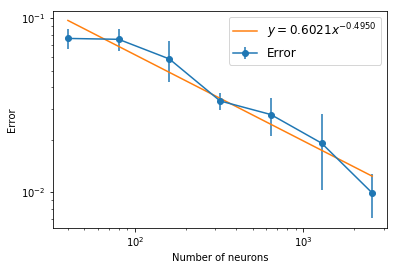

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax0= plt.subplots()
# ax0.errorbar(x[1:], np.sqrt(y[1:]), yerr=np.sqrt(error[1:])/np.sqrt(y[1:])/2, fmt='-o')
# ax0.loglog(x[start:], np.sqrt(y[start:]), '-o')
plt.xlabel("Number of neurons")
plt.ylabel("Error")
n_line = np.linspace(40,2560,1000).shape[0]
X_line = np.zeros((n_line,1))
X_line[:,0] = np.linspace(40,2560,1000)
ax0.set_xscale("log", nonposx='clip')
ax0.set_yscale("log", nonposy='clip')
# ax4.set(title='Errorbars go negative')
ax0.errorbar(x[start:], np.sqrt(y[start:]), yerr=(np.sqrt(error)/np.sqrt(y)/2)[start:], fmt='-o')
ax0.loglog(X_line[:,0], np.exp(reg.predict(np.log(X_line))))
ax0.legend(["$y=0.6021x^{-0.4950}$",'Error'],fontsize='large')

In [1]:
#Gaussian variance 0.1
import numpy as np
x=[10,20,40,80,160,320,640,1280,2560,5120,10240,20480]
y=np.array([0.04710426478529803, 0.043622320683171276, 0.012934705349529289, 0.006631332447362468, 0.0013368675651344556, 0.001593152317358832, 0.0007116385425340189, 0.000694439150288394, 0.0001755258896509471, 9.193871890294703e-05, 0.00016513021465284757, 3.470747559032566e-05])
error=np.array([0.00011953791996414422, 0.00023327789219097675, 5.6516211113193224e-05, 2.8051217603778725e-05, 1.8079378664585642e-07, 3.6144794905000906e-07, 3.465206440318263e-08, 1.260630856407966e-07, 1.169460895683422e-08, 8.085762006179582e-10, 3.591869400388453e-08, 9.103043953992167e-11])
from sklearn.linear_model import LinearRegression
start = 1
n = np.log(x[start:]).shape[0]
X = np.zeros((n,1))
X[:,0] = np.log(x[start:])
# X[:,1] = np.ones(n)
y_s = np.log(np.sqrt(y[start:]))
reg = LinearRegression().fit(X, y_s)
reg.score(X, y_s)

0.9486536177774095

In [2]:
reg.coef_, np.exp(reg.intercept_)

(array([-0.4646256]), 0.6079760120858626)

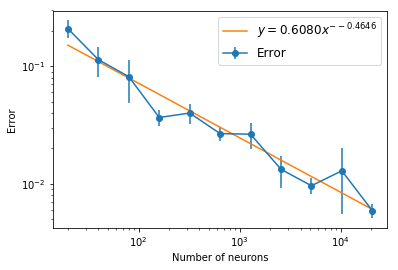

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax0= plt.subplots()
# ax0.errorbar(x[1:], np.sqrt(y[1:]), yerr=np.sqrt(error[1:])/np.sqrt(y[1:])/2, fmt='-o')
# ax0.loglog(x[start:], np.sqrt(y[start:]), '-o')
plt.xlabel("Number of neurons")
plt.ylabel("Error")
n_line = np.linspace(20,20480,1000).shape[0]
X_line = np.zeros((n_line,1))
X_line[:,0] = np.linspace(20,20480,1000)
ax0.set_xscale("log", nonposx='clip')
ax0.set_yscale("log", nonposy='clip')
# ax4.set(title='Errorbars go negative')
ax0.errorbar(x[start:], np.sqrt(y[start:]), yerr=(np.sqrt(error)/np.sqrt(y)/2)[start:], fmt='-o')
ax0.loglog(X_line[:,0], np.exp(reg.predict(np.log(X_line))))
ax0.legend(["$y=0.6080x^{--0.4646}$",'Error'],fontsize='large')

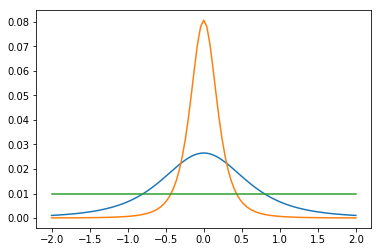

In [24]:
#zeta
fig, ax = plt.subplots()
num = 101
h = (2-(-2))/(num-1)
grid = np.linspace(start = -2, stop = 2, num = num)
a1 = 1/((1+grid**2)**2)
a2 = 1/((0.1+grid**2)**2)
a3 = np.ones(num)
plt.plot(grid, a1/np.sum(a1))
plt.plot(grid, a2/np.sum(a2))
plt.plot(grid, a3/np.sum(a3))

In [ ]:
#solutions of variational problem
fig, ax = plt.subplots()
num = 101
h = (2-(-2))/(num-1)
grid = np.linspace(start = -2, stop = 2, num = num)
a1 = 1/((1+grid**2)**2)
a2 = 1/((0.1+grid**2)**2)
a3 = np.ones(num)
plt.plot(grid, a1/np.sum(a1))
plt.plot(grid, a2/np.sum(a2))
plt.plot(grid, a3/np.sum(a3))

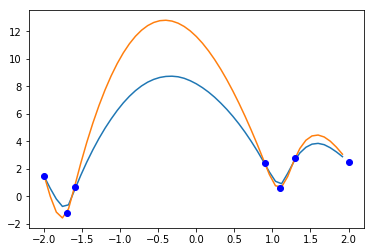

In [18]:
#original case

from scipy.interpolate import CubicSpline
xp = np.array([-2, -1.7,-1.6, 0.9, 1.1, 1.3, 2],dtype=np.float)
fp = np.array([3.5, 0.5, 2.3, 1.5, -0.5, 1.5, 0.5],dtype=np.float)+xp
cubic_spline = CubicSpline(xp, fp, bc_type='natural', extrapolate=False)

num_neurons = 10240
model = TwoLayerReluASI(num_neurons=num_neurons)
path = '/home/huijin/seminar project/model/'
tag = 'toy_model_uneven_more_'+str(num_neurons)
model_state = torch.load(path+tag+'_best'+"uniform [-2,2]")
model.load_state_dict(model_state)

test_input = np.arange(-2 , 2 , 0.08).astype(np.float32)
testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
testloader = data.DataLoader(testset, batch_size=test_input.shape[0], shuffle=False, num_workers=1)
for batch_idx, inputs in enumerate(testloader):
    outputs = model(inputs)
test_output = outputs.squeeze().detach().numpy()
true_output = np.interp(test_input, xp, fp)
# print(np.mean((true_output-test_output)**2))

fig, ax = plt.subplots()
plt.plot(test_input,test_output)
plt.plot(test_input,cubic_spline(test_input))
plt.plot(xp,fp,'bo')

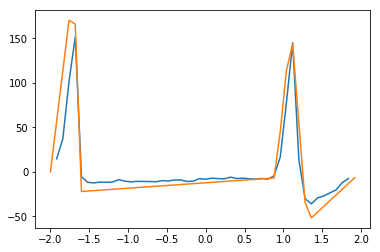

In [19]:
h=test_input[1]-test_input[0]
fig, ax = plt.subplots()
second_d_test_output=(np.concatenate((test_output[1:],test_output[-1:]))+np.concatenate((test_output[0:1],test_output[:-1]))-2*test_output)/h/h
plt.plot(test_input[1:-1],second_d_test_output[1:-1])
plt.plot(test_input,cubic_spline(test_input,2))

In [20]:
xp = np.array([-2, -1, 0, 1, 2],dtype=np.float)
fp = [1.5, 0.5, 1.5, 0.5, 1.5]

num = 101
h = (2-(-2))/(num-1)
grid = np.linspace(start = -2, stop = 2, num = num)
weight = (0.1+grid**2)**2
f = np.zeros((num))
xp_loc = (xp-(-2))/h
f[xp_loc.astype(np.int16)]=fp
def mf(ff):
    ff[xp_loc.astype(np.int16)]=fp
    return ff
# fun = lambda ff: np.sum(((np.concatenate((mf(ff)[1:],mf(ff)[-1:]))+np.concatenate((mf(ff)[0:1],mf(ff)[:-1]))
#                           -2*mf(ff))**2)*weight)
fun = lambda ff: np.sum(((mf(ff)[2:]+mf(ff)[0:-2]
                          -2*mf(ff)[1:-1])**2)*weight[1:-1])
from scipy.optimize import minimize
res = minimize(fun, f, method='CG', options={'gtol': 1e-7, 'disp': True})

         Current function value: 0.000528
         Iterations: 20200
         Function evaluations: 3258096
         Gradient evaluations: 31632


In [21]:
xp = np.array([-2, -1, 0, 1, 2],dtype=np.float)
fp = [1.5, 0.5, 1.5, 0.5, 1.5]

num = 101
h = (2-(-2))/(num-1)
grid = np.linspace(start = -2, stop = 2, num = num)
weight = (1+grid**2)**2
f = np.zeros((num))
xp_loc = (xp-(-2))/h
f[xp_loc.astype(np.int16)]=fp
def mf(ff):
    ff[xp_loc.astype(np.int16)]=fp
    return ff
# fun = lambda ff: np.sum(((np.concatenate((mf(ff)[1:],mf(ff)[-1:]))+np.concatenate((mf(ff)[0:1],mf(ff)[:-1]))
#                           -2*mf(ff))**2)*weight)
fun = lambda ff: np.sum(((mf(ff)[2:]+mf(ff)[0:-2]
                          -2*mf(ff)[1:-1])**2)*weight[1:-1])
from scipy.optimize import minimize
res1 = minimize(fun, f, method='CG', options={'gtol': 1e-7, 'disp': True})

         Current function value: 0.005046
         Iterations: 8427
         Function evaluations: 1412245
         Gradient evaluations: 13711


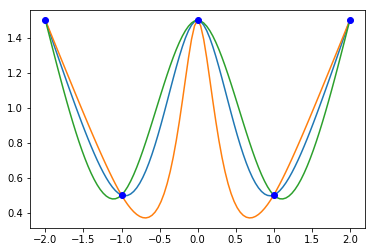

In [24]:
from scipy.interpolate import CubicSpline
xp = np.array([-2, -1, 0, 1, 2],dtype=np.float)
fp = [1.5, 0.5, 1.5, 0.5, 1.5]
cubic_spline = CubicSpline(xp, fp)

fig, ax = plt.subplots()
plt.plot(grid,res1.x)
plt.plot(grid, res.x)
cubic_spline = CubicSpline(xp, fp, bc_type='natural', extrapolate=False)
plt.plot(grid,cubic_spline(grid))
plt.plot(xp,fp,'bo')

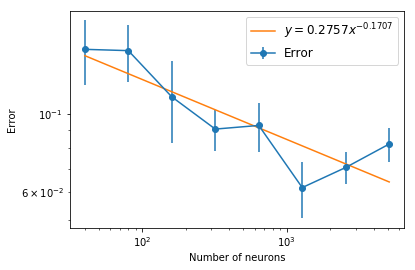

In [50]:
#large linear
import numpy as np
x=[10,20,40,80,160,320,640,1280,2560,5120]
y=np.array([0.1026797144756733, 0.03629521262443343, 0.023441018203625746, 0.02304486418254925, 0.012569736543936338, 0.008235500758974574, 0.008639371164785425, 0.0038240257024386493, 0.004977611228516881,0.006770972365240141])
error=np.array([0.002615789741367072, 0.00028787732737147863, 9.565145284188485e-05, 7.302992204821215e-05, 4.317201955627908e-05, 4.883912127976584e-06, 7.62972436665313e-06, 1.9264852312835727e-06, 1.095204965243717e-06,2.3803434023093834e-06])
from sklearn.linear_model import LinearRegression
start = 2
n = np.log(x[start:]).shape[0]
X = np.zeros((n,1))
X[:,0] = np.log(x[start:])
# X[:,1] = np.ones(n)
y_s = np.log(np.sqrt(y[start:]))
reg = LinearRegression().fit(X, y_s)
reg.score(X, y_s)

%matplotlib inline
import matplotlib.pyplot as plt
fig, ax0= plt.subplots()
# ax0.errorbar(x[1:], np.sqrt(y[1:]), yerr=np.sqrt(error[1:])/np.sqrt(y[1:])/2, fmt='-o')
# ax0.loglog(x[start:], np.sqrt(y[start:]), '-o')
plt.xlabel("Number of neurons")
plt.ylabel("Error")
n_line = np.linspace(40,5120,1000).shape[0]
X_line = np.zeros((n_line,1))
X_line[:,0] = np.linspace(40,5120,1000)
ax0.set_xscale("log", nonposx='clip')
ax0.set_yscale("log", nonposy='clip')
# ax4.set(title='Errorbars go negative')
ax0.errorbar(x[start:], np.sqrt(y[start:]), yerr=(np.sqrt(error)/np.sqrt(y)/2)[start:], fmt='-o')
ax0.loglog(X_line[:,0], np.exp(reg.predict(np.log(X_line))))
ax0.legend(["$y="+"{:.4f}".format(np.exp(reg.intercept_))+"x^{"+"{:.4f}".format(reg.coef_.squeeze())+"}$",'Error'],fontsize='large')

In [35]:
xp = np.array([-2, -1, 0, 1, 2],dtype=np.float)
fp = np.array([1.5, 0.5, 1.5, 0.5, 1.5],dtype=np.float)+10+10*xp
print(xp)
print(fp)

[-2. -1.  0.  1.  2.]
[-8.5  0.5 11.5 20.5 31.5]
